# **MVP: Simple image classifier for detecting solar radio bursts**

Part of the DSI 2022 Module 4.

## Context
Solar radio bursts are 


Recycled this project from my DSI module 1 Twist challenge to act as an MVP for my module 4 capstone project. Since the model performs quite poorly here, and my more advanced object detection using YOLOv5 performs


## Main Goal: 

*   Create MVP and backup in case main project idea (object detection) fails.


## References
1.   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
2.   https://www.pluralsight.com/guides/image-classification-with-pytorch


In [ ]:
# Importing necessary libraries

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import re

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Mounting google drive to access data

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Accessing the image dataset
#data_dir = '/content/drive/MyDrive/M4/'
data_dir_III = '/content/drive/MyDrive/M4/Burst/Type_III/'
data_dir_RFI = '/content/drive/MyDrive/M4/No_Burst/RFI/'
data_dir_classifier = '/content/drive/MyDrive/M4/classifier/'

#!ls '/content/drive/MyDrive/M4/Burst/Type_III/'

## EDA

In [ ]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

In [ ]:
ML_img = [file for file in glob.iglob(data_dir_III + '*_ML.png')]
print(len(ML_img))

142


In [ ]:
!pip install split-folders

In [ ]:
# import splitfolders
# splitfolders.ratio(data_dir_III, output=data_dir_III, seed=1337, ratio=(.9, 0.1,0)) 
# splitfolders.ratio(data_dir_RFI, output=data_dir_RFI, seed=1337, ratio=(.9, 0.1,0)) 


In [ ]:
# def train_val_dataset(dataset, val_split=0.25):
#     train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
#     datasets = {}
#     datasets['train'] = Subset(dataset, train_idx)
#     datasets['val'] = Subset(dataset, val_idx)
#     return datasets

# dataset = ImageFolder(data_dir, transform=Compose([Resize((224,224)),ToTensor()]))
# print(len(dataset))
# datasets = train_val_dataset(dataset)
# print(len(datasets['train']))
# print(len(datasets['val']))
# # The original dataset is available in the Subset class
# print(datasets['train'].dataset)

# dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train','val']}
# x,y = next(iter(dataloaders['train']))
# print(x.shape, y.shape)

In [ ]:
# Processing the images for display

data_process = {
    'train': transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

processed_images = {x: datasets.ImageFolder(os.path.join(data_dir_classifier, x),
                                          data_process[x])
                  for x in ['train', 'val']}

dataloaders_base = {x: torch.utils.data.DataLoader(processed_images[x], batch_size=4,
                            shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(processed_images[x]) for x in ['train', 'val']}
class_names = processed_images['train'].classes   

print(dataset_sizes)
print(class_names)

{'train': 244, 'val': 27}
['III', 'RFI']


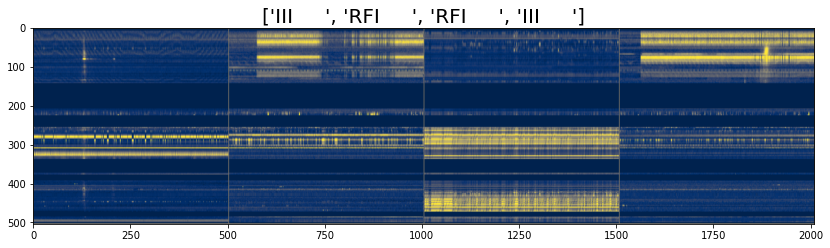

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize = '20')
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders_base['train']))

print(dataloaders_base['train'])

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

title_list = [class_names[x] + '     ' for x in classes]

fig = plt.figure(figsize=(14,8))
imshow(out, title=title_list)

In [ ]:
print(dataset_sizes)

{'train': 244, 'val': 27}


In [ ]:
print(class_names)

['III', 'RFI']


In [ ]:
# Getting paths of sub-directories
train_path = data_dir_classifier + 'train/'
val_path = data_dir_classifier + 'val/'

train_burst = train_path + 'III/'
train_RFI = train_path + 'RFI/'
val_burst = val_path + 'III/'
val_RFI = val_path + 'RFI/'

RFI = [train_RFI, val_RFI]
burst = [train_burst, val_burst]

# Getting total count of RFI mushrooms
RFI_count = 0
for i in range(0, len(RFI)):
  path, dirs, files = next(os.walk(RFI[i]))
  RFI_count += len(files)
  #print(RFI_count)

# Getting total count of burst mushrooms
burst_count = 0
for i in range(0, len(RFI)):
  path, dirs, files = next(os.walk(burst[i]))
  burst_count += len(files)

print('Total number of RFI mushrooms: ', RFI_count)
print('Total number of burst mushrooms: ', burst_count)

total_count = [RFI_count, burst_count]

Total number of RFI mushrooms:  130
Total number of burst mushrooms:  141


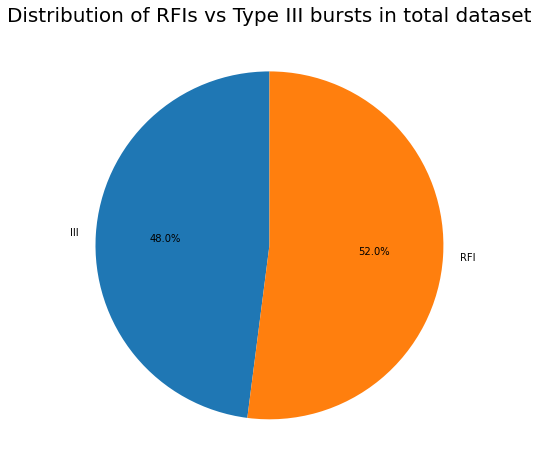

In [ ]:
# Visualising the dataset repartition
plt.figure(figsize = (8,8))
plt.pie(total_count, labels = class_names, autopct='%1.1f%%', shadow=False, startangle=90)
plt.title('Distribution of RFIs vs Type III bursts in total dataset', fontsize = '20')
plt.show()

## Training

In [ ]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

num_workers = 2

data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize((500, 500)),
        transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize((500, 500)),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir_classifier, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

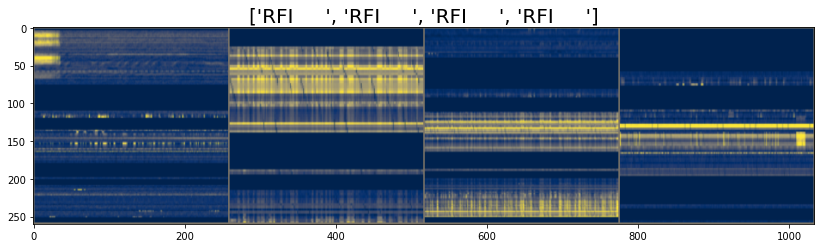

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(dataloaders['train'])

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

title_list = [class_names[x] + '     ' for x in classes]

# Visualising training data and augmentations
fig = plt.figure(figsize=(14,8))
imshow(out, title=title_list)


In [ ]:
epoch_no = 1

In [ ]:
# Defining training function to schedule the learning rate and save best model

def train_model(model, criterion, optimizer, scheduler, num_epochs=epoch_no):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Defining function to visualise images with their predictions compared to ground truth

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(6,6))
    

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {}'.format(class_names[preds[j]]) + 
                             '\nActual: {}'.format(class_names[labels[j]]), 
                             fontsize = '16')         
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine-tuning the CNN
Loading the Resnet18 pretrained model.

Resetting final fully connected layer.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Training and evaluating
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epoch_no)

Epoch 0/0
----------
train Loss: 0.7193 Acc: 0.6025
val Loss: 0.5985 Acc: 0.7407

Training complete in 1m 43s
Best val Acc: 0.740741


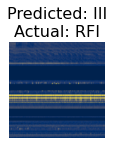

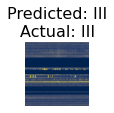

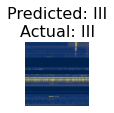

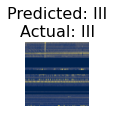

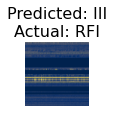

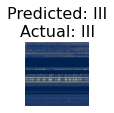

In [ ]:
# Call the function
visualize_model(model_ft)

In [ ]:
# Freezing whole network except final layer. 
# Set requires_grad = False to freeze the parameters so that the gradients are not computed in backward()

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# Training and evaluating
# usually takes less time than previous training since most gradients do not need to be computed for most of network
# note: forward is still computed
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=epoch_no)

Epoch 0/0
----------
train Loss: 0.6965 Acc: 0.6148
val Loss: 0.8504 Acc: 0.5556

Training complete in 0m 37s
Best val Acc: 0.555556


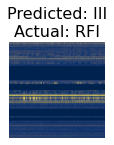

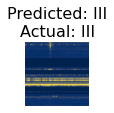

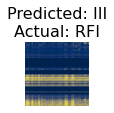

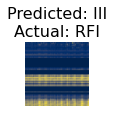

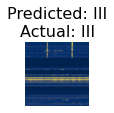

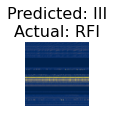

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
# Save 
torch.save(model_conv.state_dict(), 'model_conv.ckpt')

**WEB APP**

In [ ]:
!pip install --quiet gradio

     |████████████████████████████████| 2.9 MB 8.6 MB/s 
     |████████████████████████████████| 253 kB 66.7 MB/s 
     |████████████████████████████████| 212 kB 63.1 MB/s 
     |████████████████████████████████| 84 kB 2.1 MB/s 
     |████████████████████████████████| 1.1 MB 56.3 MB/s 
     |████████████████████████████████| 2.0 MB 50.7 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 54 kB 1.8 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 271 kB 59.3 MB/s 
     |████████████████████████████████| 144 kB 45.6 MB/s 
     |████████████████████████████████| 10.9 MB 35.7 MB/s 
     |████████████████████████████████| 58 kB 4.8 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 4.0 MB 47.6 MB/s 
     |████████████████████████████████| 856 kB 44.3 MB/s 
     |██████████████████████

In [ ]:
model_path = 'model_conv.ckpt'
state_dict = torch.load(model_path)
#print(state_dict.keys())
model_conv.load_state_dict(state_dict)
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import PIL

import gradio as gr
import torch
from torchvision import transforms
import requests
from PIL import Image

sample = '/content/drive/My Drive/M4/classifier/samples/'

labels = ['RFI', 'burst']

def predict_image(Input):
  Input = Image.fromarray(Input.astype('uint8'), 'RGB')
  Input = transforms.ToTensor()(Input).unsqueeze(0)
  with torch.no_grad():
    prediction = torch.nn.functional.softmax(model_conv(Input)[0], dim=0)
  return {labels[i]: float(prediction[i]) for i in range(2)}

image = gr.inputs.Image()
label = gr.outputs.Label(num_top_classes=2)
#gr.Interface(fn=predict_image, inputs=image, outputs=label).launch()
title = 'RFI vs Solar Radio Burst'
description = 'DISCLAIMER: Proof-of-concept MVP!'
examples=[['samples/HUMAIN_20220427_100000_ML.png'],
          ['samples/HUMAIN_20220427_101500_ML.png'],
          ['samples/HUMAIN_20220427_103000_ML.png'],
          ['samples/HUMAIN_20220427_104500_ML.png'],
          ['samples/HUMAIN_20220501_051500_ML.png'],
          ['samples/HUMAIN_20220501_071500_ML.png'],
          ['samples/HUMAIN_20220501_081500_ML.png'],
          ['samples/HUMAIN_20220501_114500_ML.png'],
          ['samples/HUMAIN_20220501_133000_ML.png'],
          ['samples/HUMAIN_20220501_153000_ML.png'],
          ['samples/HUMAIN_20220502_064500_ML.png']]
thumbnail = 'thumbnail.jpg'
article = '''
<!DOCTYPE html>
<html>
<body>
<br>
<p>
Images obtained from: <a href="https://wwwbis.sidc.be/humain/callisto_latest"> SIDC ROB Humain Callisto instrument</a>
</p>
<br>
<p><i>By: Akhil Gunessee</i></p> 
</body>
</html>
'''

iface = gr.Interface(fn=predict_image, 
                     inputs=image, 
                     outputs=label,
                     interpretation='default',
                     title = title,
                     description = description,
                     theme = 'dark-peach',
                     examples = examples,
                     thumbnail = thumbnail,
                     article = article,
                     allow_flagging = False,
                     allow_screenshot = False,                     
                    )
iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/interface.py:383: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  "The `allow_flagging` parameter in `Interface` now"


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://46656.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
